# Non-negative Matrix Factorization (NMF) Topic Modeling

In [1]:
#Import necessary libraries
import numpy as np
import pandas as pd
import scipy.sparse as sp
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary

In [2]:
#Load and explore pre-processed text
df = pd.read_csv('processced text.csv')
#df

In [3]:
#Had issues with saved tfidf matrix and vectorizer so created new vectorizer and refit - can fix later
vec = TfidfVectorizer(max_df=0.95, min_df=2, max_features=1000)
tfidf = vec.fit_transform(df['preprocessed_text'])

In [4]:
feature_names = vec.get_feature_names_out()

In [5]:
#Set random state
random_state = 696

**Initially Test and Explore NMF with 2 Topics**

In [6]:
dictionary = Dictionary(df['preprocessed_text'].apply(lambda x: list(x)))

In [7]:
nmf = NMF(n_components = 2, random_state = random_state, max_iter = 200, init = 'nndsvd')
W = nmf.fit_transform(tfidf)
H = nmf.components_

In [8]:
#Function that retrieves the top terms for a given topic
def get_terms(H, topic):
    top_term_indices = np.argsort(H[topic])[::-1]
    top_terms = [feature_names[i] for i in top_term_indices[:50]]
    return top_terms

In [9]:
topic_terms = get_terms(H,0)

In [10]:
#Print top 50 terms for the first topic
topic_terms

['united',
 'states',
 'trump',
 'government',
 'president',
 'politic',
 'election',
 'party',
 'donald',
 'republican',
 'house',
 'washington',
 'obama',
 'say',
 'biden',
 'international',
 'us',
 'presidential',
 'federal',
 'military',
 'defense',
 'american',
 'force',
 'senate',
 'state',
 'democratic',
 'war',
 'department',
 'court',
 'ukraine',
 'china',
 'we',
 'relation',
 'would',
 'official',
 'world',
 'coronavirus',
 'leader',
 'white',
 'news',
 'russia',
 'right',
 'economy',
 'make',
 'economic',
 'year',
 'immigration',
 'country',
 'jr',
 'national']

In [11]:
coherence_model = CoherenceModel(topics=topic_terms, texts=df['preprocessed_text'], dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()

In [12]:
coherence_score

0.4342463218534655

**Do hyperparameter tuning with different number of topics to determine which model has the highest coherence score**

In [13]:
coherence_scores = []
best_avg_coherence = 0
best_model = None
best_W = None
best_H = None

for num_topics in range(2,11):
    nmf = NMF(n_components = num_topics, 
                  max_iter = 200, init = 'nndsvd', random_state = random_state)
    W = nmf.fit_transform(tfidf)
    H = nmf.components_
    
    t_cs = []
    for topic in range(num_topics):
        topic_terms = get_terms(H,topic)
        coherence_model = CoherenceModel(topics=topic_terms, texts=df['preprocessed_text'], 
                                         dictionary=dictionary, coherence='c_v')
        t_cs.append(coherence_model.get_coherence())
    avg_c = np.mean(t_cs)
    coherence_scores.append(avg_c)
    if avg_c > best_avg_coherence:
        best_avg_coherence = avg_c
        best_model = nmf
        best_W = W
        best_H = H

/Users/yashdave/anaconda3/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [14]:
best_model

NMF(init='nndsvd', n_components=8, random_state=696)

In [15]:
best_avg_coherence

0.4703757749803664

In [16]:
coherence_scores

[0.4616273324255159,
 0.468823822830144,
 0.46325249708195726,
 0.46229288430027743,
 0.4620266095150089,
 0.466002693904566,
 0.4703757749803664,
 0.4703121877392168,
 0.4673511241103199]

**Visualize the results of hyperparameter tuning**

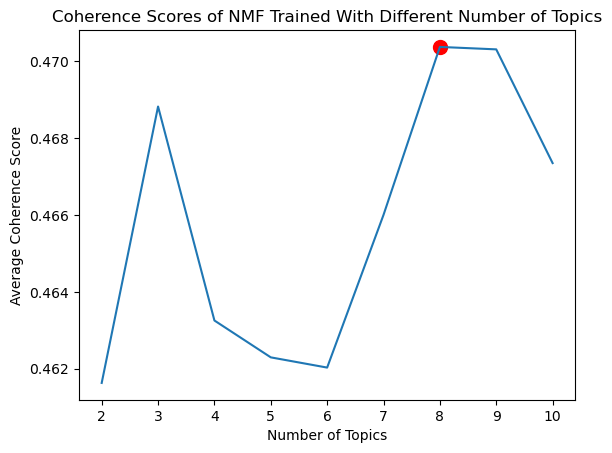

In [17]:
plt.plot(np.arange(2,11), coherence_scores)
plt.xlabel('Number of Topics')
plt.ylabel('Average Coherence Score')
plt.title('Coherence Scores of NMF Trained With Different Number of Topics')
plt.scatter(best_model.n_components, coherence_scores[best_model.n_components -2], c='red', marker='o', s=100)

In [18]:
#View the top terms for each generated topic for the best NMF Model
for t in range(best_model.n_components):
    print('Topic', str(t+1) + ':', get_terms(best_H, t))

Topic 1: ['trump', 'united', 'states', 'government', 'president', 'politic', 'election', 'donald', 'party', 'republican', 'house', 'obama', 'washington', 'biden', 'presidential', 'senate', 'us', 'democratic', 'international', 'state', 'military', 'defense', 'federal', 'american', 'force', 'relation', 'jr', 'say', 'ukraine', 'department', 'white', 'war', 'leader', 'barack', 'campaign', 'economy', 'russia', 'immigration', 'joseph', 'we', 'administration', 'court', 'official', 'law', 'political', 'economic', 'would', 'russian', 'afghanistan', 'china']
Topic 2: ['new', 'york', 'city', 'jersey', 'state', 'lottery', 'connecticut', 'number', 'mayor', 'ny', 'nyc', 'year', 'manhattan', 'de', 'cuomo', 'blasio', 'metropolitan', 'times', 'bloomberg', 'bill', 'andrew', 'michael', 'estate', 'real', 'brooklyn', 'citys', 'park', 'housing', 'residential', 'restaurant', 'budget', 'public', 'street', 'authority', 'department', 'gov', 'win', 'met', 'school', 'education', 'area', 'police', 'system', 'hurri

**Visualize the top terms for each topic generated by our best model -> Need to ask Alexis if using source is ok**

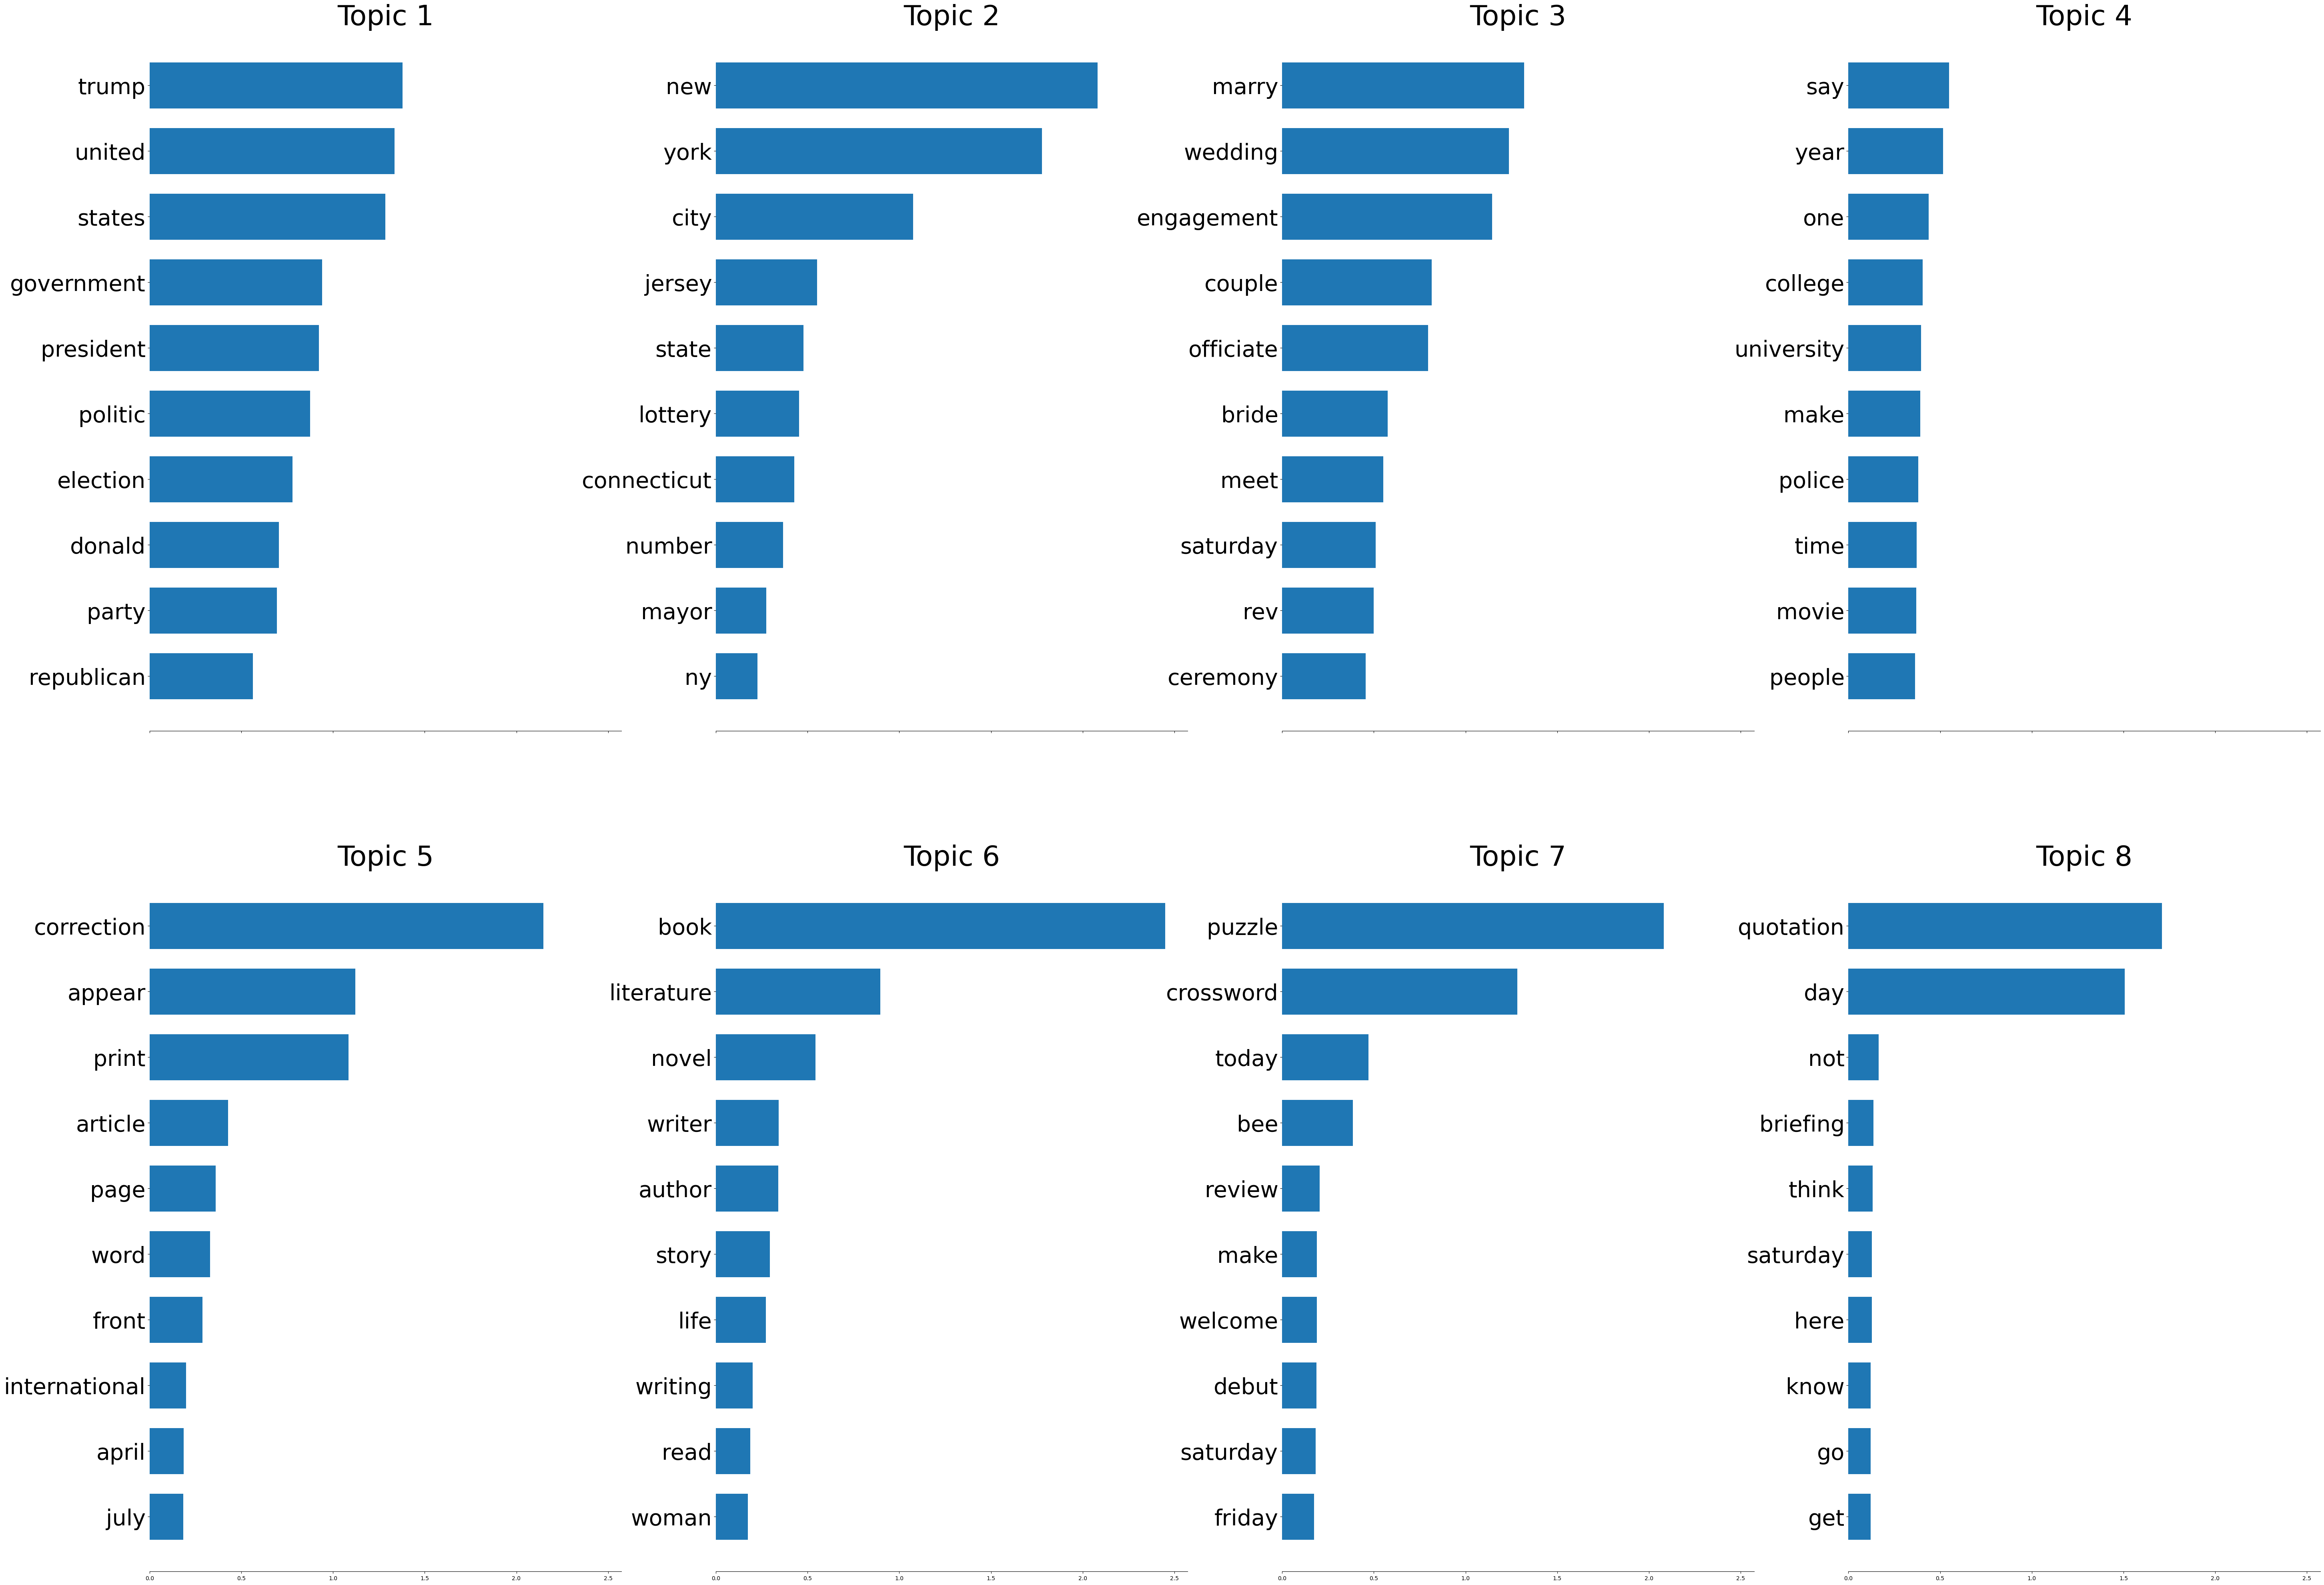

In [19]:
#Source: https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html
fig, axes = plt.subplots(2, 4, figsize=(70, 50), sharex=True)
axes = axes.flatten()
for topic_idx, topic in enumerate(best_H):
        top_features_ind = topic.argsort()[-10:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]
        
        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 50})
        ax.tick_params(axis='y', labelsize=40)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)

**Based on this analysis, the 8 topics from the best NMF model can be categorized as:** <p><p>
Topic 1: Politics and World News<p>
Topic 2: Local News <p>
Topic 3: Religion <p>
Topic 4: Entertainment and Sports <p>
Topic 5: Editor's Desk <p>
Topic 6: Literature and Arts <p>
Topic 7: Crosswords and Puzzles <p>
Topic 8: Opinion <p>

**References**<p>
https://www.kaggle.com/code/rockystats/topic-modelling-using-nmf<p>
https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html<p>
https://tedboy.github.io/nlps/generated/generated/gensim.models.CoherenceModel.html<p>